# Solution - Problem Set 3

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz

###Import data

In [3]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p datashim
!cp /content/drive/Shareddrives/DS602-F22/Data/data602.py ./datashim
from datashim import data602

Mounted at /content/drive


In [4]:
# CDF only needed if used for #1
#cdf = data602.read_citations()
wdf = data602.read_weather()

# Question 1 -- Statistical data visualization 
In the first assignment, problem 3, you identified an ``interesting'' pattern in the weather or citations dataset.  Recall that discovered knowledge should be novel, useful, and non-trivial.  Develop a explanatory visualization to present the knowledge you discovered.  (You may choose a different pattern from the one you used in the first homework assignment if you wish.) 

#Question 2 -- Data preparation

This problem uses the weather dataset from previous problem sets.  Prepare a dataset to predict the observed temperature from the following predictors:

* The non-temperature fields from the observation
* The temperature recorded in the prior observation

Beginning with the weather dataset:

a. Add the temperature from the prior reading as a new feature.  That is, for each observation at time $t_k$, $k>0$, the new feature should have the value of the temperature reading at time $t_{k-1}$.  For the first observation ($k=0$), the value should be missing because the prior temperature is unknown.


In [7]:
# add prior temp field
wdf['tmp_meas'] = wdf['tmp_meas'].interpolate()
wdf['prior_temp'] = wdf['tmp_meas'].shift(1)

wdf

,date,wnd_speed,tmp_meas,precip,precip_intensity,cloudcover,tstorm,winter,mist,fog,prior_temp
0,2015-12-31 19:54:00-05:00,1.5,7.2,0.0,0,4.0,0,0,0,0,NaN
1,2015-12-31 20:54:00-05:00,3.1,6.1,0.0,0,4.0,0,0,0,0,7.2
2,2015-12-31 21:54:00-05:00,2.1,6.7,0.0,0,4.0,0,0,0,0,6.1
3,2015-12-31 22:54:00-05:00,2.6,6.1,0.0,0,4.0,0,0,0,0,6.7
4,2015-12-31 23:54:00-05:00,2.1,5.6,0.0,0,4.0,0,0,0,0,6.1
...,...,...,...,...,...,...,...,...,...,...,...
58462,2022-09-02 12:54:00-04:00,4.6,27.8,NaN,0,3.0,0,0,0,0,26.1
58463,2022-09-02 13:54:00-04:00,2.6,28.9,NaN,0,3.0,0,0,0,0,27.8
58464,2022-09-02 14:54:00-04:00,4.1,28.9,NaN,0,3.0,0,0,0,0,28.9
58465,2022-09-02 15:54:00-04:00,4.6,29.4,NaN,0,3.0,0,0,0,0,28.9


b. Because the observed temperature is the target variable, remove the current temperature from the data frame, and save the values into a matrix $\mathbf{y}$

In [8]:
y = wdf.pop('tmp_meas')
y

0         7.2
1         6.1
2         6.7
3         6.1
4         5.6
         ... 
58462    27.8
58463    28.9
58464    28.9
58465    29.4
58466    30.0
Name: tmp_meas, Length: 58467, dtype: float64

d. Remove the non-numeric date field

In [18]:
# remove date field
wdf = wdf.loc[1:, wdf.columns != 'date'] 

In [19]:
wdf

,wnd_speed,precip,precip_intensity,cloudcover,tstorm,winter,mist,fog,prior_temp
1,3.1,0.0,0,4.0,0,0,0,0,7.2
2,2.1,0.0,0,4.0,0,0,0,0,6.1
3,2.6,0.0,0,4.0,0,0,0,0,6.7
4,2.1,0.0,0,4.0,0,0,0,0,6.1
5,2.1,0.0,0,4.0,0,0,0,0,5.6
...,...,...,...,...,...,...,...,...,...
58462,4.6,NaN,0,3.0,0,0,0,0,26.1
58463,2.6,NaN,0,3.0,0,0,0,0,27.8
58464,4.1,NaN,0,3.0,0,0,0,0,28.9
58465,4.6,NaN,0,3.0,0,0,0,0,28.9


d. Construct and apply a ColumnTransformer that inputs the dataset into a matrix that is suitable for machine learning.

In [20]:
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (RobustScaler, MinMaxScaler, 
                                   MaxAbsScaler, QuantileTransformer,
                                   FunctionTransformer)
from scipy.sparse import csc_matrix

ct = make_column_transformer(
      (
          make_pipeline(KNNImputer(), RobustScaler()),
          ["wnd_speed"]
      ),
      (
          # note: a KNN imputer and standard/robust scaler
          # is acceptable.
          make_pipeline(
              KNNImputer(),
              FunctionTransformer(lambda x: csc_matrix(x)),
              QuantileTransformer(ignore_implicit_zeros=True)
          ),
          ["precip"]
      ),
      (
          make_pipeline(KNNImputer(), MinMaxScaler()),
          ["cloudcover", "precip_intensity"]
      ),
      (RobustScaler(), ["prior_temp"]),
      remainder="passthrough"
    )


#apply the transformation and describe the output
xt = ct.fit_transform(wdf)
pd.DataFrame(xt).describe()

,0,1,2,3,4,5,6,7,8
count,58466.000000,58466.000000,58466.000000,58466.000000,58466.000000,58466.000000,58466.000000,58466.000000,58466.000000
mean,0.148976,0.037181,0.512377,0.033541,-0.030148,0.005388,0.009920,0.091044,0.006688
std,0.887997,0.152518,0.256102,0.118742,0.610433,0.073204,0.099106,0.287675,0.081505
min,-1.000000,0.000000,0.000000,0.000000,-1.862275,0.000000,0.000000,0.000000,0.000000
25%,-0.423077,0.000000,0.400000,0.000000,-0.532934,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.576923,0.000000,0.800000,0.000000,0.467066,0.000000,0.000000,0.000000,0.000000
max,5.923077,1.000000,1.000000,1.000000,1.365269,1.000000,1.000000,1.000000,1.000000


Justifications will vary. One approach is to use the nearest neighbor imputation, but interpolation or forward filling is also acceptable.  Responses may note uneven distribution of missing values for precipitation.

We use a MinMaxScaler for precip_intensity and cloudcover, both of which are known to fall within a specific range.  We use a robust scaler for wind speed, which is subject to outliers but generally fall within a well-defined range.  Since precipitation is typically zero, we use a MaxAbs scaler to scale to 1 without affecting sparsity. We do the same for prior temperature (but a StandardScalar would be justifiable as well; since the data is slightly bimodal, a robust scaler accomodates the higher IQR caused by bimodality.)  The date column is not scaled, but rather transformed using the scalar written for the first question.  The remaining elements are dummy variables and passed through as-is.

Precipation is difficult to scale because it is very highly skewed (the large majorit of values are zero), and also highly kurtotic with a few extreme outliers.  We need to trade off between (a) keeping the data on the same relative scale, and (b) maintaining separation between points at different scales.  RobustScaler fails here because the IQR is zero (the 25th and 75 percentiles are zero), and QuantileTransformer also performs poorly using the default hyperparameters because it attempts to spread out the most frequent value, which here is exactly zero.  We have a few options:

1. Scale using MinMaxScaler or MaxAbsScaler.  This is a reasonable approach, although the majority of values will be compressed to be very close to zero (99th percentile is 0.04, and std=0.013).

2. Scale using QuantileTransformer, setting the `ignore_implicit_zeros` hyperparameter to 1.  This approach ignores zeros and produces a slightly wider distribution (sd=0.15).  The documentation indicates that this hyperparameter requires a sparse matrix, so we need to convert before passing to the transformer.

The performance of either approach can be tested in downstream modeling.

Ensure absence of null values:

In [23]:
np.any(np.isnan(xt))

False

Print the first few values of X and Y.

{'X': array([[0.1923, 0.0000, 0.8000, 0.0000, -0.4671, 0.0000, 0.0000, 0.0000, 0.0000],
       [-0.1923, 0.0000, 0.8000, 0.0000, -0.5329, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.8000, 0.0000, -0.4970, 0.0000, 0.0000, 0.0000, 0.0000],
       [-0.1923, 0.0000, 0.8000, 0.0000, -0.5329, 0.0000, 0.0000, 0.0000, 0.0000],
       [-0.1923, 0.0000, 0.8000, 0.0000, -0.5629, 0.0000, 0.0000, 0.0000, 0.0000],
       [-1.0000, 0.0000, 0.6000, 0.0000, -0.5988, 0.0000, 0.0000, 0.0000, 0.0000],
       [-0.4231, 0.0000, 0.8000, 0.0000, -0.6347, 0.0000, 0.0000, 0.0000, 0.0000],
       ...,
       [0.5769, 0.0000, 0.6000, 0.0000, 0.5629, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.1923, 0.0000, 0.6000, 0.0000, 0.6347, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.7692, 0.0000, 0.6000, 0.0000, 0.6647, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 0.6000, 0.0000, 0.7665, 0.0000, 0.0000, 0.0000, 0.0000],
       [0.5769, 0.0000, 0.6000, 0.0000, 0.8323, 0.0000, 0.0000, 0.0000, 0.0000]

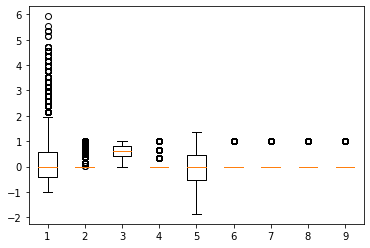

In [21]:
plt.boxplot(xt)

with np.printoptions(precision=4, formatter={'float': '{:0.4f}'.format}, edgeitems=7, linewidth=200):
    print({"X": xt, "y": y})